Created by Virendra Pratap Singh (vpsn_99@yahoo.com)
Sep-Oct 2025

In [2]:
# =========================================================
# STEP 1: SETUP & CONFIGURATION (GPU + Local Copy Ready)
# =========================================================
!pip install -q tensorflow==2.19.0 scikit-learn matplotlib

import os, json, pickle, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# --- PARAMETERS ---
USE_DRIVE = True        # set True if data is on Drive
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 10
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
SEED = 123

# --- PATH HANDLING ---
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_DATA = "/content/drive/My Drive/AI-ML-Learn/COVID-XRay-Split"

    # copy dataset locally for faster I/O
    if not os.path.exists("/content/COVID-XRay-Split"):
        print("Copying dataset from Drive to Colab local storage...")
        !cp -r "/content/drive/My Drive/AI-ML-Learn/COVID-XRay-Split" /content/
    DATA_DIR = "/content/COVID-XRay-Split"
else:
    DATA_DIR = os.path.join(os.getcwd(), "COVID-XRay-Split")

OUTPUT_DIR = os.path.join(os.getcwd(), "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

CLS_PATH   = os.path.join(OUTPUT_DIR, "covid_class_names.json")
BEST_PATH  = os.path.join(OUTPUT_DIR, "best_model.keras")
LAST_PATH  = os.path.join(OUTPUT_DIR, "last_epoch.keras")
FINAL_PATH = os.path.join(OUTPUT_DIR, "covid_classifier_final.keras")
HISTORY_PATH = os.path.join(OUTPUT_DIR, "train_history.pkl")

tf.random.set_seed(SEED)

# Check GPU availability
print("Available devices:", tf.config.list_physical_devices('GPU'))
if not tf.config.list_physical_devices('GPU'):
    print("WARNING: No GPU detected. Switch runtime → GPU for faster training.")
else:
    print("GPU detected and ready for training!")

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Mounted at /content/drive
Copying dataset from Drive to Colab local storage...
Available devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU detected and ready for training!
Data directory: /content/COVID-XRay-Split
Output directory: /content/outputs


In [3]:
# =========================================================
# STEP 2: LOAD DATASETS (with caching & prefetch)
# =========================================================
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Save class names
with open(CLS_PATH, "w") as f:
    json.dump(class_names, f)

# Add caching for fast subsequent epochs
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache("/content/train_cache.tfdata").prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache("/content/val_cache.tfdata").prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)

Found 14814 files belonging to 4 classes.
Found 4232 files belonging to 4 classes.
Found 2119 files belonging to 4 classes.
Classes: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [4]:
# =========================================================
# STEP 3: MODEL DEFINITION
# =========================================================
def build_model(num_classes):
    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
    base.trainable = False
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model, base

In [5]:
# =========================================================
# STEP 4: PHASE 1 - TRAIN CLASSIFIER HEAD
# =========================================================
if os.path.exists(BEST_PATH):
    print("Found existing checkpoint — skipping Phase 1.")
    model = keras.models.load_model(BEST_PATH)
else:
    model, base = build_model(num_classes)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    ckpt_best = keras.callbacks.ModelCheckpoint(BEST_PATH, save_best_only=True, monitor="val_accuracy", mode="max")
    ckpt_last = keras.callbacks.ModelCheckpoint(LAST_PATH, save_freq="epoch")
    early     = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    print("Starting Phase 1 training...")
    history1 = model.fit(
        train_ds, validation_data=val_ds,
        epochs=EPOCHS_PHASE1, callbacks=[ckpt_best, ckpt_last, early], verbose=1
    )

    # Save training history
    with open(HISTORY_PATH, "wb") as f:
        pickle.dump(history1.history, f)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Starting Phase 1 training...
Epoch 1/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 177s 161ms/step - accuracy: 0.7094 - loss: 0.7254 - val_accuracy: 0.8530 - val_loss: 0.4059
Epoch 2/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 58s 63ms/step - accuracy: 0.8264 - loss: 0.4654 - val_accuracy: 0.8651 - val_loss: 0.3648
Epoch 3/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.8322 - loss: 0.4364 - val_accuracy: 0.8710 - val_loss: 0.3441
Epoch 4/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.8426 - loss: 0.4173 - val_accuracy: 0.8748 - val_loss: 0.3337
Epoch 5/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - accuracy: 0.8469 - loss: 0.4038 - val_accuracy: 0.8809 - val_loss: 0.3232
Epoch 6/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.8451 - loss: 0.4055 - val_accuracy: 0.8811 - val_loss: 0.3203
Epoch 7/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.8493 - loss: 0.3975 - val_accuracy: 0.8790 - val_loss: 0.3235
Epoch 8/

In [6]:
# =========================================================
# STEP 5: PHASE 2 – FINE-TUNE BASE LAYERS
# =========================================================
import gc, tensorflow as tf
gc.collect()
tf.keras.backend.clear_session()

# Reload the best checkpoint from Phase 1
model = keras.models.load_model(BEST_PATH)

# Retrieve the EfficientNet base by its name (set in Step 3)
try:
    base = model.get_layer("efficientnet_base")
    print(f"Found base model: {base.name}")
except ValueError:
    # fallback (if base not named correctly)
    base = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            base = layer
            print(f"Found base submodel: {base.name}")
            break
    if base is None:
        raise ValueError("EfficientNet base not found in loaded model!")

# =========================================================
# Configure layers for fine-tuning
# =========================================================
base.trainable = True

# Freeze first ~70 % of layers
freeze_until = int(len(base.layers) * 0.7)
for layer in base.layers[:freeze_until]:
    layer.trainable = False

trainable_count = sum([layer.trainable for layer in base.layers])
print(f"Fine-tuning {trainable_count}/{len(base.layers)} layers in base model.")

# =========================================================
# Compile the model with a smaller learning rate
# =========================================================
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# =========================================================
# Define callbacks
# =========================================================
ckpt_best = keras.callbacks.ModelCheckpoint(
    BEST_PATH, save_best_only=True, monitor="val_accuracy", mode="max"
)
ckpt_last = keras.callbacks.ModelCheckpoint(
    LAST_PATH, save_freq="epoch"
)
early = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# =========================================================
# Start fine-tuning
# =========================================================
print("Starting Phase 2 fine-tuning...")
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=[ckpt_best, ckpt_last, early],
    verbose=1
)

# =========================================================
# Save updated training history
# =========================================================
import pickle
with open(HISTORY_PATH, "ab") as f:
    pickle.dump(history2.history, f)

# =========================================================
# Save the final fine-tuned model
# =========================================================
model.save(FINAL_PATH)
print("Final fine-tuned model saved at:", FINAL_PATH)


Found base submodel: efficientnetb0
Fine-tuning 72/238 layers in base model.
Starting Phase 2 fine-tuning...
Epoch 1/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 109s 81ms/step - accuracy: 0.6601 - loss: 0.9143 - val_accuracy: 0.8887 - val_loss: 0.3174
Epoch 2/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.8436 - loss: 0.4322 - val_accuracy: 0.9076 - val_loss: 0.2618
Epoch 3/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.8714 - loss: 0.3459 - val_accuracy: 0.9147 - val_loss: 0.2396
Epoch 4/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.8877 - loss: 0.3034 - val_accuracy: 0.9230 - val_loss: 0.2200
Epoch 5/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.9018 - loss: 0.2695 - val_accuracy: 0.9244 - val_loss: 0.2110
Epoch 6/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.9144 - loss: 0.2414 - val_accuracy: 0.9279 - val_loss: 0.2017
Epoch 7/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.9188 - loss: 0.2212 - val_accuracy: 0.9312

133/133 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.9372 - loss: 0.1876

Test Accuracy: 0.9320 | Test Loss: 0.2005

Classification Report:
                 precision    recall  f1-score   support

          COVID     0.9777    0.9669    0.9722       362
   Lung_Opacity     0.9160    0.8870    0.9013       602
         Normal     0.9229    0.9500    0.9362      1020
Viral Pneumonia     0.9531    0.9037    0.9278       135

       accuracy                         0.9320      2119
      macro avg     0.9424    0.9269    0.9344      2119
   weighted avg     0.9322    0.9320    0.9319      2119


Weighted F1: 0.9319 | Macro F1: 0.9344


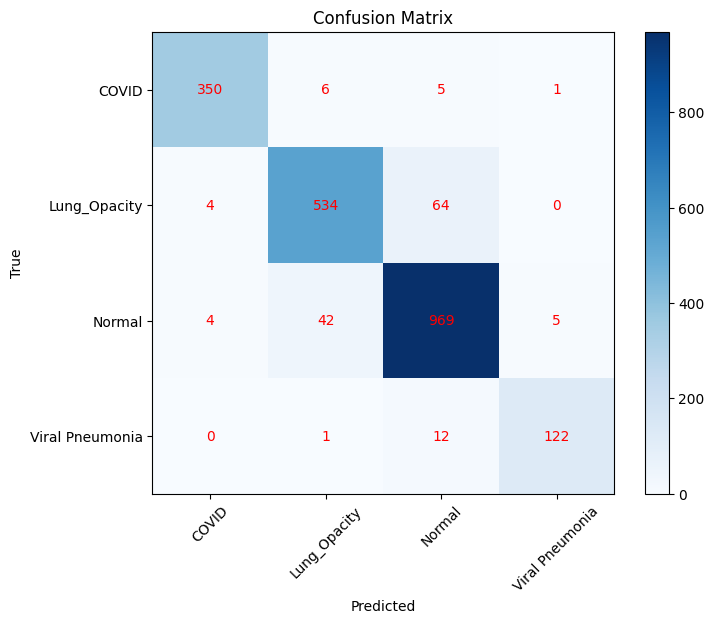

In [7]:
# =========================================================
# STEP 6: EVALUATION
# =========================================================
best_model = keras.models.load_model(BEST_PATH)

test_loss, test_acc = best_model.evaluate(test_ds, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

y_true, y_pred = [], []
for xb, yb in test_ds:
    preds = best_model.predict(xb, verbose=0)
    y_true.extend(yb.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

f1_weighted = f1_score(y_true, y_pred, average="weighted")
f1_macro    = f1_score(y_true, y_pred, average="macro")
print(f"\nWeighted F1: {f1_weighted:.4f} | Macro F1: {f1_macro:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(num_classes), class_names, rotation=45)
plt.yticks(np.arange(num_classes), class_names)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="red")
plt.colorbar()
plt.show()


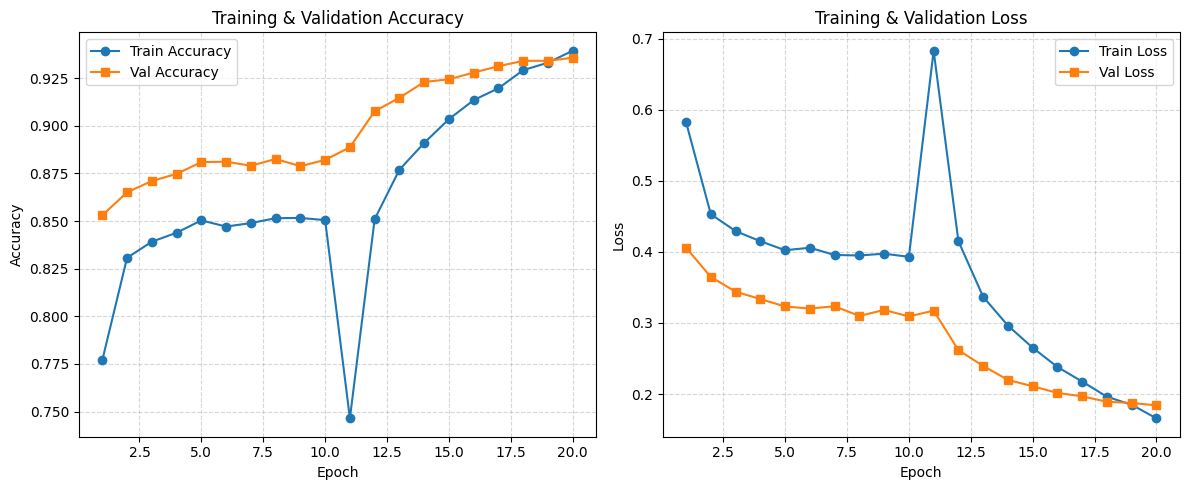

Training curves saved at: /content/outputs/training_curves.png


In [8]:
# =========================================================
# STEP 7: PLOT TRAINING CURVES (PHASE 1 + PHASE 2)
# =========================================================
import os, pickle
import matplotlib.pyplot as plt

# Load saved histories
with open(HISTORY_PATH, "rb") as f:
    histories = []
    try:
        while True:
            histories.append(pickle.load(f))
    except EOFError:
        pass

# Merge phase histories
history = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
for h in histories:
    for k in history.keys():
        if k in h:
            history[k].extend(h[k])

# Plot
epochs = range(1, len(history["accuracy"]) + 1)
plt.figure(figsize=(12,5))

# Accuracy subplot
plt.subplot(1,2,1)
plt.plot(epochs, history["accuracy"], label="Train Accuracy", marker="o")
plt.plot(epochs, history["val_accuracy"], label="Val Accuracy", marker="s")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Loss subplot
plt.subplot(1,2,2)
plt.plot(epochs, history["loss"], label="Train Loss", marker="o")
plt.plot(epochs, history["val_loss"], label="Val Loss", marker="s")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
curve_path = os.path.join(OUTPUT_DIR, "training_curves.png")
plt.savefig(curve_path, dpi=200)
plt.show()

print(f"Training curves saved at: {curve_path}")
